In [1]:
## Bring in needed mods
import pandas as pd, numpy as np, glob
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from matplotlib import pyplot as plt
%matplotlib inline

## Write functions for parseing and printing blat files
def parse_psl(path,sr = 5,hd = None,rs=6, psl_cols = ['match','mismatch','rep_match', 
            'Ns','Q_gap_count','Q_gap_bases', 'T_gap_count',
            'T_gap_bases','T_strand', 'Q_name', 'Q_size', 'Q_start', 'Q_end', 'T_name', 
            'T_size', 'T_start', 'T_end','block_count', 'block_sizes', 'qStarts', 'tStarts']):
    psl_df = pd.read_csv(path,sep='\t',skiprows=sr,header=hd)
    psl_df.columns = psl_cols
    psl_df['Q_frac'] = np.round(psl_df['match']/psl_df['Q_size'],rs)
    psl_df.sort_values('Q_frac',ascending=False,inplace=True)
    psl_df.reset_index(drop=True,inplace=True)
    return psl_df

In [2]:
gtd = pd.read_csv('./Bt65_prog_QTL_info.csv',index_col=0)
gtd['Chrom'] = gtd.Contig
gtd['Oldalt'] = gtd['Alt']
gtd['Alt'] = [g.split('.')[-1] for g in gtd.Alt]

In [3]:
gtd[['Ref','Alt','Oldalt']].head()

,Ref,Alt,Oldalt
0,C,T,C.T
1,C,T,C.T
2,C,G,C.G
3,A,T,A.T
4,A,G,A.G


In [4]:
columns = gtd.columns.tolist()

In [5]:
posix = columns.index('Pos')

In [6]:
other = columns[posix:]

In [7]:
print(other)

['Pos', 'Contig', 'DPmin', 'Alt', 'Ref', 'Type', 'Altlen', 'Qual', 'NALT', 'AF', 'Bt65', 'crg1', 'Pval', 'Chrom', 'Oldalt']


In [8]:
prog = columns[:posix]

In [9]:
gtd.Chrom.unique()

array(['Chr_1', 'Chr_13', 'Chr_12', 'Chr_10', 'Chr_7', 'Chr_11', 'Chr_3',
       'Chr_14', 'Chr_2', 'Chr_5', 'Chr_4', 'Chr_6', 'Chr_9', 'Chr_8'],
      dtype=object)

In [10]:
chrom_3 = gtd[(gtd.Chrom=='Chr_3')]
chrom_11 = gtd[(gtd.Chrom=='Chr_11')]

In [11]:
## Bring in phenotype data
data = pd.read_excel('../PHENOTYPE/RAW/F1-progeny-info.xlsx')
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)
data.index = data['F1 Progeny #']
to_use_data = data.loc[[int(a) for a in prog]]['Mutation rate (quantitative)'].copy()*(10**9)

In [12]:
pheno = np.log(to_use_data+1)

In [13]:
pheno.sort_values(ascending=False).head()

F1 Progeny #
19    6.160891
34    6.148212
24    6.030709
32    5.923855
44    5.736830
Name: Mutation rate (quantitative), dtype: float64

In [14]:
temp_prog = [str(a) for a in pheno.sort_values().index]

In [15]:
import matplotlib.gridspec as gridspec

In [16]:
chrom_3[(chrom_3.Pval >= chrom_3.Pval.max())].Pos.min()
chrom_3[(chrom_3.Pval >= chrom_3.Pval.max())].Pos.max()

1118629.0

In [17]:
# List samples we know to have aneuploidy
baddies = np.array([[25],[25],[14,25],[25,34],[25],[25],[25],[25],
                    [25],[25],[13,14,25],[25],[20,25,29],[25]],
                  dtype='object')

In [18]:
dontuse = [str(a) for a in np.unique(np.concatenate(baddies[[2,10]]))] + ['12','41']

In [19]:
dontuse

['13', '14', '25', '12', '41']

In [20]:
sorted_prog = [a for a in temp_prog if a not in dontuse]
#sorted_prog = [a for a in temp_prog if a not in dontuse[1:]]

In [21]:
py = range(len(sorted_prog))

In [22]:
znf = np.array([970996,976412])

In [23]:
chr3_bounds = np.array([chrom_3[(chrom_3.Pval >= 
                     chrom_3.Pval.max())].Pos.min()/1000.0,
            chrom_3[(chrom_3.Pval >= 
                     chrom_3.Pval.max())].Pos.max()/1000.0])

In [24]:
chr11_bounds = np.array([chrom_11[(chrom_11.Pval >= 
                      chrom_11.Pval.max())].Pos.min()/1000.0,
            chrom_11[(chrom_11.Pval >= 
                      chrom_11.Pval.max())].Pos.max()/1000.0])

In [25]:
len(sorted_prog)

23

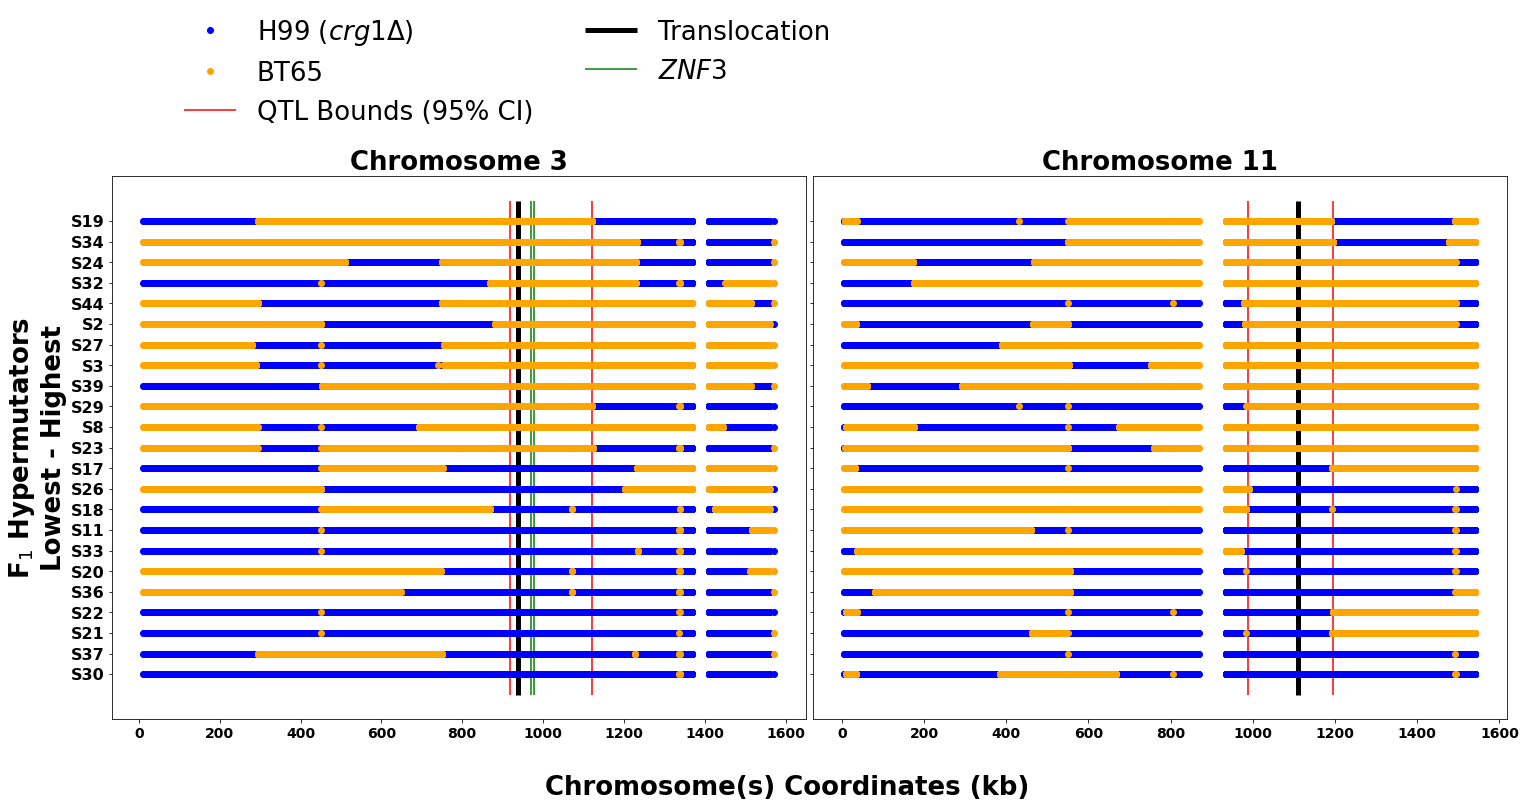

In [26]:
fig, ax = plt.subplots(1,2,figsize=(25,10),sharey=True)
plt.sca(ax[0])
plt.title('Chromosome 3',fontsize=26,fontweight='bold')


chr3_ci = np.array([918548,1120200])/1000
plt.vlines(chr3_ci,-1,len(sorted_prog),color='r',label='QTL Bounds (95% CI)')
plt.vlines(938233/1000,-1,len(py),'k',linewidth=5,label='Translocation');
plt.vlines(znf/1000,-1,len(py),'g',label='$ZNF3$')
for i,pr in enumerate(sorted_prog):
    temp = chrom_3[['Pos',pr]]
    plt.plot(temp[temp[pr]==0].Pos/1000.0,
             np.repeat(py[i],len(temp[temp[pr]==0])),
             'o',color='blue',label='H99 ($crg1\Delta$)' if i == 0 else None)
    plt.plot(temp[temp[pr]==1].Pos/1000.0,
             np.repeat(py[i],len(temp[temp[pr]==1])),
             'o',color='orange',label='BT65'if i == 0 else None)

plt.yticks(py,['S%s'%s for s in sorted_prog],fontsize=16,fontweight='bold')
plt.ylabel('F$_1$ Hypermutators\nLowest - Highest',
           fontsize=26,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')


plt.sca(ax[1])
plt.title('Chromosome 11',fontsize = 26,fontweight='bold')
chr11_ci = np.array([987379,1193972])/1000
plt.vlines(chr11_ci,-1,len(sorted_prog),color='r')
del temp
for i,pr in enumerate(sorted_prog):
    temp = chrom_11[['Pos',pr]]

    plt.plot(temp[temp[pr]==0].Pos/1000.0,
             np.repeat(py[i],len(temp[temp[pr]==0])),'o',
                 color='blue')
    plt.plot(temp[temp[pr]==1].Pos/1000.0,
             np.repeat(py[i],len(temp[temp[pr]==1])),'o',
                 color='orange')
#plt.legend(fontsize=26,bbox_to_anchor=(-0.3, -0.07),frameon=False)
plt.subplots_adjust(hspace=0.02,wspace=0.01,)
fig.text(0.5,0.03,'Chromosome(s) Coordinates (kb)',
         fontsize=26,ha='center',va='center',fontweight='bold');
plt.subplots_adjust(hspace=0.001)

plt.vlines(1109626/1000,-1,len(py),'k',linewidth=5);

#plt.arrow(chrom_11.Pos.max()/1000,-10,-10000,0);
plt.xticks(fontsize=14,fontweight='bold')

arrow_properties = dict(
    facecolor="black", width=0.5,
    headwidth=4, shrink=0.1)



plt.sca(ax[0]);
plt.legend(ncol=2,fontsize=26,frameon=False,bbox_to_anchor=(0.07,1.05))


#filename = '../FIGS/Bt65-crg1-F1-hypermuators-chr3&11-trans.png'
#filename = '/Users/croth/Desktop/Bt65-crg1-F1-hypermuators-chr3&11-trans.png'
filename = '/Users/croth/Desktop/Hypermutator/FIGS/paper/Supplementary_Figure_S3_Bt65-crg1-F1-hypermuators-chr3&11-trans.png'


#fig.savefig(filename,dpi=150,bbox_inches='tight')

In [27]:
import os
Vikas_fasta_path = '/home/croth/Hypermutator_mac/DATA/H99_latest_Vikas_assembly.fasta'
Fungidb_fasta_path  = '/home/croth/Hypermutator_mac/DATA/FungiDB-46_CneoformansH99_Genome.fasta'
gffpath = '/home/croth/QTL-functions/DATA/REFERENCE/FungiDB-46_CneoformansH99.gff.gz'

In [28]:
h99gff = pd.read_csv(gffpath,
                     skiprows=17,sep='\t',header=None)
h99gff.columns = ['Chrom','Source','Type','Start','End','Skip','Strand','Phase','ID']
h99gff['Gene'] = ['CNAG_'+ a.split(';')[0].split('CNAG_')[-1][:5] for a in h99gff.ID]
h99gff[h99gff.Type=='gene'].tail()

,Chrom,Source,Type,Start,End,Skip,Strand,Phase,ID,Gene
133974,CP003830.1,EuPathDB,gene,315320,315742,.,-,.,ID=CNAG_12972;description=unspecified product,CNAG_12972
133977,CP003820.1,EuPathDB,gene,324325,327655,.,-,.,ID=CNAG_00122;description=Alpha-amylase,CNAG_00122
133997,CP003822.1,EuPathDB,gene,1018998,1021264,.,-,.,ID=CNAG_02685;description=hypothetical protein,CNAG_02685
134013,CP003826.1,EuPathDB,gene,961030,963232,.,+,.,ID=CNAG_12683;description=unspecified product,CNAG_12683
134018,CP003822.1,EuPathDB,gene,252266,254097,.,+,.,ID=CNAG_02995;description=RNA-binding protein ...,CNAG_02995


In [29]:
chrlist = sorted(h99gff.Chrom.unique())
ch3_h99 = chrlist[2]
ch11_h99 = chrlist[10]

In [30]:
h99genome = [s for s in SeqIO.parse(Vikas_fasta_path,format='fasta')]

In [31]:
ZNF3 = 'CNAG_02700'
gene = ZNF3
chrom = 'Chr_3'

In [32]:
chr11_bounds

array([ 991.049, 1189.364])

In [33]:
genes_3_df = h99gff[(h99gff.Type=='gene') & 
                 (h99gff.End>=1000*chr3_bounds[0]) & 
                 (h99gff.Start<=1000*chr3_bounds[1]) & 
                   (h99gff.Chrom==ch3_h99)]

genes_11_df = h99gff[(h99gff.Type=='gene') & 
                 (h99gff.End>=1000*chr11_bounds[0]) & 
                 (h99gff.Start<=1000*chr11_bounds[1]) & 
                   (h99gff.Chrom==ch11_h99)]

In [34]:
genes_11_df.Start.min(),genes_11_df.End.max()

(989854, 1190646)

In [35]:
gene_3 = genes_3_df.Gene.tolist()
gene_11 = genes_11_df.Gene.tolist()

In [36]:
len(gene_3)

108

In [37]:
len(gene_11)

85

In [38]:
chrom

'Chr_3'

In [39]:
pwd


'/home/croth/Hypermutator_QTL/NOTEBOOKS'

In [47]:
chrom='Chr_11'
for gene in gene_11:
    #if os.path.exists('../FILES/GENES/%s.csv'%gene):
    #    continue
    temp = h99gff[(h99gff.Gene==gene)][['Type','Start','End']].drop_duplicates()
    genegff = h99gff.T[temp.index].T

    cdsgff = genegff[(genegff.Type=='CDS')].copy().reset_index(drop=True)
    
    if cdsgff.shape[0] == 0:
        continue
        
    cdsgff['CDS'] = [int(a.split(';')[0].split('-CDS')[-1]) for a in cdsgff.ID]
    cdsgff['Parent'] = [int(a.split('-p')[0][-1]) for a in cdsgff['ID'].tolist()]
    
    pp = cdsgff.groupby('Parent').count().idxmax().max()
    
    cdsgff = cdsgff[(cdsgff.Parent==pp)].sort_values(['Start','End','CDS'])
    
    if cdsgff.shape[0] == 0:
        continue
        
    fasta = [s for s in h99genome if s.id == ''.join(chrom.split('_'))][0]
    strand = cdsgff.Strand.unique()[0]

    cdsseq = []
    cdspos = []
    cdscds = []
    cdspha = []

    ## This is one based
    for i,j in cdsgff.iterrows():
        cdspos.append(np.arange(j.Start,j.End+1))
        cdsseq.append(fasta.seq[j.Start-1:j.End])
        cdscds.append(j.CDS*np.ones(len(np.arange(j.Start,j.End+1))))
        cdspha.append(int(j.Phase)*np.ones(len(np.arange(j.Start,j.End+1))))
    
    assert np.sum(np.array([len(a) for a in cdsseq],dtype=int)) == np.sum(
        np.array(cdsgff[['Start','End']].T.diff().T.End.values,dtype=int)+1)
    assert len(np.concatenate(cdspos)) == np.sum(np.array([len(a) for a in cdsseq],dtype=int))
    assert strand == genegff.Strand.unique()
    assert cdsgff.CDS.max() == cdsgff.shape[0]

    cdsdf = pd.DataFrame([np.concatenate(cdspos),np.concatenate(cdscds),np.concatenate(cdspha),
                      [a for a in ''.join([str(a) for a in cdsseq])]]).T
    cdsdf.columns = ['Pos','CDS','Phase','Fasta']
    cdsdf['Strand'] = strand
    cdsdf['Ref'] = cdsdf['Fasta']
    cdsdf['Alt'] = cdsdf['Fasta']
    cdsdf['Gene'] = gene
    cdsdf['Chrom'] = chrom
    cdsdf['Parent'] = pp
    cdsdf.index = cdsdf.Pos

    gene_gv = gtd[(gtd.Chrom==chrom) & (gtd.Pos.isin(cdsdf.Pos))].copy()
    gene_gv.index = gene_gv.Pos

    cdsdf.loc[gene_gv.index,'Ref'] = gene_gv['Ref']
    cdsdf.loc[gene_gv.index,'Alt'] = gene_gv['Alt']

    cdsdf['GV'] = [ 1 if str(p.Alt) != str(p.Ref) else 0 for l,p in cdsdf.iterrows()]
    cdsdf['Refflag'] = [ 1 if str(p.Fasta) != str(p.Ref) else 0 for l,p in cdsdf.iterrows()]

    assert cdsdf[(cdsdf.GV==1)].shape[0] == gene_gv.shape[0]

    if strand == '-':
        altseq = Seq(''.join(cdsdf.Alt.tolist())).reverse_complement()
        refseq = Seq(''.join(cdsdf.Ref.tolist())).reverse_complement()
        fastaseq = Seq(''.join(cdsdf.Fasta.tolist())).reverse_complement()
    else:
        altseq = Seq(''.join(cdsdf.Alt.tolist()))
        refseq = Seq(''.join(cdsdf.Ref.tolist()))
        fastaseq = Seq(''.join(cdsdf.Fasta.tolist()))
    
    al = len(altseq.translate(to_stop=True))
    rl = len(refseq.translate(to_stop=True))
    fl = len(fastaseq.translate(to_stop=True))

    cdsdf['ALT=REF'] = [1 if al == rl else 0][0]
    cdsdf['ATL>REF'] = [1 if al > rl else 0][0]
    cdsdf['FASTA=REF'] = [1 if fl == rl else 0][0]
    cdsdf['FASTA=ALT'] = [1 if fl == al else 0][0]
    cdsdf['REF>FASTA'] = [1 if rl > fl else 0][0]
    cdsdf['ALT>FASTA'] = [1 if al > fl else 0][0]
    cdsdf['Absdif'] = np.abs(al-rl)/rl

    cdsdf.to_csv('../GENOTYPE/GENES/%s.csv'%gene,index=False)

/home/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/home/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/home/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/home/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may

In [49]:
didnt_11 = []
for g in gene_11:
    if not os.path.exists('../GENOTYPE/GENES/%s.csv'%g):
        didnt_11.append(g)
len(didnt_11)

8

In [50]:
h99gff[(h99gff.Gene.isin(didnt_11)) & (h99gff.Type=='gene')]

,Chrom,Source,Type,Start,End,Skip,Strand,Phase,ID,Gene
5161,CP003830.1,EuPathDB,gene,1124719,1125172,.,-,.,ID=CNAG_13013;description=unspecified product,CNAG_13013
23459,CP003830.1,EuPathDB,gene,1181539,1183614,.,+,.,ID=CNAG_13015;description=unspecified product,CNAG_13015
37319,CP003830.1,EuPathDB,gene,1021154,1022301,.,+,.,ID=CNAG_13009;description=unspecified product,CNAG_13009
37357,CP003830.1,EuPathDB,gene,1082466,1084457,.,+,.,ID=CNAG_13011;description=unspecified product,CNAG_13011
51826,CP003830.1,EuPathDB,gene,1157105,1157858,.,-,.,ID=CNAG_13014;description=unspecified product,CNAG_13014
95485,CP003830.1,EuPathDB,gene,1090510,1091028,.,+,.,ID=CNAG_13012;description=unspecified product,CNAG_13012
110640,CP003830.1,EuPathDB,gene,1009834,1010261,.,-,.,ID=CNAG_13008;description=unspecified product,CNAG_13008
128399,CP003830.1,EuPathDB,gene,1048124,1048640,.,+,.,ID=CNAG_13010;description=unspecified product,CNAG_13010


In [51]:
didnt_3 = []
for g in gene_3:
    if not os.path.exists('../GENOTYPE/GENES/%s.csv'%g):
        didnt_3.append(g)
len(didnt_3)

26

In [52]:
h99gff[(h99gff.Gene.isin(didnt_3)) & (h99gff.Type=='gene')]

,Chrom,Source,Type,Start,End,Skip,Strand,Phase,ID,Gene
634,CP003822.1,EuPathDB,gene,1104486,1105762,.,-,.,ID=CNAG_12298;description=unspecified product,CNAG_12298
1078,CP003822.1,EuPathDB,gene,1012931,1013442,.,+,.,ID=CNAG_12288;description=unspecified product,CNAG_12288
2053,CP003822.1,EuPathDB,gene,937421,937681,.,-,.,ID=CNAG_12281;description=unspecified product,CNAG_12281
3371,CP003822.1,EuPathDB,gene,1070521,1072161,.,+,.,ID=CNAG_12291;description=unspecified product,CNAG_12291
11673,CP003822.1,EuPathDB,gene,900438,901020,.,+,.,ID=CNAG_12275;description=unspecified product,CNAG_12275
16506,CP003822.1,EuPathDB,gene,1093631,1096145,.,-,.,ID=CNAG_12293;description=unspecified product,CNAG_12293
20358,CP003822.1,EuPathDB,gene,970759,971144,.,+,.,ID=CNAG_12282;description=unspecified product,CNAG_12282
25072,CP003822.1,EuPathDB,gene,906717,907883,.,-,.,ID=CNAG_12277;description=unspecified product,CNAG_12277
36679,CP003822.1,EuPathDB,gene,959193,959295,.,-,.,ID=CNAG_10029;description=unspecified product,CNAG_10029
38880,CP003822.1,EuPathDB,gene,1008898,1010239,.,-,.,ID=CNAG_12287;description=unspecified product,CNAG_12287


In [53]:
qtl3df = []
for g in gene_3:
    if g in didnt_3:
        continue
    else:
        qtl3df.append(pd.read_csv('../GENOTYPE/GENES/%s.csv'%g,index_col=0))
qtl3df = pd.concat(qtl3df)

In [54]:
qtl3df.shape

(144489, 18)

In [62]:
def nonsynonmous(df):
    
    if df.Strand.min() == '+':
        
        Ref = Seq(''.join(df.Ref.tolist())).translate()
        Alt = Seq(''.join(df.Alt.tolist())).translate()
    
    if df.Strand.min() == '-':

        Ref = Seq(''.join(df.Ref.tolist())).reverse_complement().translate()
        Alt = Seq(''.join(df.Alt.tolist())).reverse_complement().translate()
    
    diffs = []
    k = np.min([len(Ref),len(Alt)])
    for i in range(k):
        
        if Alt[i] != Ref[i]:
            diffs.append(1)
        else:
            diffs.append(0)
    return(np.sum(diffs))

In [63]:
qtl3df.head()

,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA,Absdif
Pos,,,,,,,,,,,,,,,,,,
1026018,1.0,0.0,A,+,A,A,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
1026019,1.0,0.0,T,+,T,T,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
1026020,1.0,0.0,G,+,G,G,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
1026021,1.0,0.0,A,+,A,A,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
1026022,1.0,0.0,C,+,C,C,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0


In [64]:
gv_in_cds

7

In [65]:
qtl3df

,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA,Absdif
Pos,,,,,,,,,,,,,,,,,,
1026018,1.0,0.0,A,+,A,A,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
1026019,1.0,0.0,T,+,T,T,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
1026020,1.0,0.0,G,+,G,G,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
1026021,1.0,0.0,A,+,A,A,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
1026022,1.0,0.0,C,+,C,C,CNAG_02684,Chr_3,1,0,0,1,0,1,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021092,1.0,0.0,A,-,A,A,CNAG_02685,Chr_3,1,0,0,1,0,0,0,0,0,0.0
1021093,1.0,0.0,C,-,C,C,CNAG_02685,Chr_3,1,0,0,1,0,0,0,0,0,0.0
1021094,1.0,0.0,C,-,C,C,CNAG_02685,Chr_3,1,0,0,1,0,0,0,0,0,0.0


In [67]:
gene3_diffs = []
for g in qtl3df.Gene.unique():
    
    total_gv = gtd[(gtd.Chrom==qtl3df[(qtl3df.Gene==g)].Chrom.unique().max()) & 
    (gtd.Pos<= h99gff[(h99gff.Gene==g) & (h99gff.Type=='gene')].End.max()) & 
    (gtd.Pos>= h99gff[(h99gff.Gene==g) & (h99gff.Type=='gene')].Start.min())].shape[0]
    
    gv_in_cds = qtl3df[(qtl3df.Gene==g)].GV.sum()
    
    
    gene3_diffs.append((g,total_gv,gv_in_cds,nonsynonmous(qtl3df[(qtl3df.Gene==g)][['Ref','Alt','Strand']])))
    
gene3_diffsdf = pd.DataFrame(gene3_diffs)
gene3_diffsdf.columns = ['Gene','# of SNPs','SNPs in Exons','# Nsyn changes']
gene3_diffsdf['Stop-gain'] = 'no'
gene3_diffsdf['Stop-loss'] = 'no'

/home/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/home/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/home/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,
/home/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may

In [68]:
gene3_diffsdf.head()

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss
0,CNAG_02684,45,8,1,no,no
1,CNAG_02670,15,9,6,no,no
2,CNAG_02659,23,7,100,no,no
3,CNAG_02689,15,4,3,no,no
4,CNAG_02711,0,0,0,no,no


In [70]:
gene3_diffsdf[(gene3_diffsdf['# Nsyn changes']>0)].shape

(71, 6)

In [71]:
max3df = qtl3df.groupby('Gene').max()

In [72]:
max3df[(max3df['FASTA=ALT']==0)].index.tolist()

['CNAG_02659',
 'CNAG_02660',
 'CNAG_02662',
 'CNAG_02665',
 'CNAG_02666',
 'CNAG_02667',
 'CNAG_02670',
 'CNAG_02677',
 'CNAG_02678',
 'CNAG_02680',
 'CNAG_02681',
 'CNAG_02683',
 'CNAG_02685',
 'CNAG_02690',
 'CNAG_02694',
 'CNAG_02696',
 'CNAG_02698',
 'CNAG_02699',
 'CNAG_02700',
 'CNAG_02701',
 'CNAG_02702',
 'CNAG_02704',
 'CNAG_02705',
 'CNAG_02706',
 'CNAG_02708',
 'CNAG_02712',
 'CNAG_02713',
 'CNAG_02715',
 'CNAG_02716',
 'CNAG_02717',
 'CNAG_02719',
 'CNAG_02720',
 'CNAG_02721',
 'CNAG_02723',
 'CNAG_02724',
 'CNAG_02729',
 'CNAG_02730',
 'CNAG_07524',
 'CNAG_07527',
 'CNAG_07528',
 'CNAG_07969']

In [73]:
gene3_diffsdf.index = gene3_diffsdf.Gene

In [74]:
gene3_diffsdf.T[max3df[(max3df['FASTA=ALT']==0)].index.tolist()].T

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss
Gene,,,,,,
CNAG_02659,CNAG_02659,23,7,100,no,no
CNAG_02660,CNAG_02660,23,19,9,no,no
CNAG_02662,CNAG_02662,55,39,91,no,no
CNAG_02665,CNAG_02665,34,25,19,no,no
CNAG_02666,CNAG_02666,16,14,6,no,no
CNAG_02667,CNAG_02667,21,12,8,no,no
CNAG_02670,CNAG_02670,15,9,6,no,no
CNAG_02677,CNAG_02677,15,6,0,no,no
CNAG_02678,CNAG_02678,15,4,4,no,no


In [75]:
for gene,j in max3df[(max3df['FASTA=ALT']==0)].iterrows():
    
    if j['ALT>FASTA'] == 0:
        
        gene3_diffsdf.loc[gene,'Stop-gain'] = 'yes'
    else:
        assert j['ALT>FASTA'] == 1
        gene3_diffsdf.loc[gene,'Stop-loss'] = 'yes'

In [76]:
gene3_diffsdf[(gene3_diffsdf['Stop-gain']=='yes') | 
              (gene3_diffsdf['Stop-loss']=='yes')]

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss
Gene,,,,,,
CNAG_02670,CNAG_02670,15,9,6,yes,no
CNAG_02659,CNAG_02659,23,7,100,no,yes
CNAG_02713,CNAG_02713,36,3,1,no,yes
CNAG_02660,CNAG_02660,23,19,9,no,yes
CNAG_02730,CNAG_02730,23,16,5,yes,no
CNAG_02683,CNAG_02683,36,12,10,yes,no
CNAG_02681,CNAG_02681,38,23,10,yes,no
CNAG_02698,CNAG_02698,15,12,7,yes,no
CNAG_02662,CNAG_02662,55,39,91,yes,no


In [77]:
gene3_diffsdf.tail()

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss
Gene,,,,,,
CNAG_02655,CNAG_02655,3,1,0,no,no
CNAG_02720,CNAG_02720,15,11,107,yes,no
CNAG_02676,CNAG_02676,11,5,1,no,no
CNAG_07525,CNAG_07525,1,1,0,no,no
CNAG_02685,CNAG_02685,20,12,35,yes,no


In [78]:
max3df[(max3df['FASTA=REF']==0)]

,CDS,Phase,Fasta,Strand,Ref,Alt,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA,Absdif
Gene,,,,,,,,,,,,,,,,,
CNAG_02659,7.0,1.0,T,-,T,T,Chr_3,2,1,1,0,0,0,0,1,1,0.011494
CNAG_02660,8.0,2.0,T,+,T,T,Chr_3,1,1,1,1,0,0,0,1,1,0.000000
CNAG_02662,6.0,2.0,T,-,T,TGC,Chr_3,1,1,1,1,0,0,0,0,0,0.000000
CNAG_02665,8.0,1.0,T,+,T,TTA,Chr_3,1,1,1,1,0,0,0,0,0,0.000000
CNAG_02666,3.0,2.0,T,+,T,T,Chr_3,1,1,1,1,0,0,0,1,1,0.000000
CNAG_02667,7.0,2.0,T,+,TTC,T,Chr_3,1,1,1,1,0,0,0,0,0,0.000000
CNAG_02670,5.0,2.0,T,-,TC,TGGAA,Chr_3,1,1,1,1,0,0,0,0,0,0.000000
CNAG_02677,11.0,2.0,T,+,T,TGGA,Chr_3,1,1,1,1,0,0,0,1,1,0.000000
CNAG_02678,10.0,2.0,T,-,T,T,Chr_3,1,1,1,1,0,0,0,0,0,0.000000


In [79]:
max3df[(max3df['ALT=REF']==0)]

,CDS,Phase,Fasta,Strand,Ref,Alt,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA,Absdif
Gene,,,,,,,,,,,,,,,,,
CNAG_02659,7.0,1.0,T,-,T,T,Chr_3,2,1,1,0,0,0,0,1,1,0.011494
CNAG_02680,15.0,2.0,T,-,T,T,Chr_3,1,1,1,0,1,0,0,0,0,10.594203
CNAG_02694,3.0,1.0,T,-,TC,TCTCT,Chr_3,2,1,1,0,0,0,0,0,0,0.491803
CNAG_02700,9.0,0.0,T,-,TGG,TTTGT,Chr_3,1,1,1,0,0,0,0,0,0,0.839527
CNAG_02701,2.0,1.0,T,-,TC,T,Chr_3,1,1,1,0,1,0,0,0,0,0.002075
CNAG_02704,2.0,1.0,T,+,T,T,Chr_3,1,1,1,0,0,0,0,0,0,0.008000
CNAG_02720,7.0,2.0,T,+,T,T,Chr_3,1,1,1,0,0,0,0,0,0,0.001818
CNAG_02721,7.0,2.0,T,-,T,TG,Chr_3,1,1,1,0,0,0,0,0,0,0.004950
CNAG_07969,2.0,0.0,T,+,TGT,TT,Chr_3,1,1,1,0,1,0,0,0,0,2.413793


In [82]:
unknown_07528 = pd.read_csv('../FILES/GENES/%s.csv'%max3df[(max3df['ALT=REF']==0)].index.tolist()[1])

FileNotFoundError: [Errno 2] No such file or directory: '../FILES/GENES/CNAG_02680.csv'

In [83]:
len(Seq(''.join(unknown_07528.Alt.tolist())).reverse_complement().translate(to_stop=True))

NameError: name 'unknown_07528' is not defined

In [84]:
len(Seq(''.join(unknown_07528.Ref.tolist())).reverse_complement().translate(to_stop=True))

NameError: name 'unknown_07528' is not defined

In [80]:
h99gff[(h99gff.Type=='gene') & (h99gff.Gene.isin(max3df[(max3df['ALT=REF']==0)].index))]

,Chrom,Source,Type,Start,End,Skip,Strand,Phase,ID,Gene
5705,CP003822.1,EuPathDB,gene,1096380,1097930,.,-,.,ID=CNAG_02659;description=hypothetical protein...,CNAG_02659
27023,CP003822.1,EuPathDB,gene,968153,970487,.,-,.,ID=CNAG_02701;description=hypothetical protein,CNAG_02701
37002,CP003822.1,EuPathDB,gene,908141,913426,.,-,.,ID=CNAG_02721;description=leucine repeat conta...,CNAG_02721
43326,CP003822.1,EuPathDB,gene,930460,931520,.,+,.,ID=CNAG_07969;description=hypothetical protein,CNAG_07969
70416,CP003822.1,EuPathDB,gene,959349,960325,.,+,.,ID=CNAG_02704;description=hypothetical protein,CNAG_02704
93511,CP003822.1,EuPathDB,gene,1038093,1043768,.,-,.,ID=CNAG_02680;description=VPS15 protein kinase,CNAG_02680
104164,CP003822.1,EuPathDB,gene,970996,976412,.,-,.,ID=CNAG_02700;description=C2H2 type zinc finge...,CNAG_02700
119196,CP003822.1,EuPathDB,gene,998795,1002468,.,-,.,ID=CNAG_02694;description=hypothetical protein...,CNAG_02694
125228,CP003822.1,EuPathDB,gene,913679,916146,.,+,.,ID=CNAG_02720;description=nuclear GTP-binding ...,CNAG_02720


In [552]:
unknown_3 = pd.read_csv('../FILES/GENES/CNAG_07528.csv')

In [555]:
len(Seq(''.join(unknown_3.Ref.tolist())).reverse_complement().translate(to_stop=True))

463

In [556]:
len(Seq(''.join(unknown_3.Alt.tolist())).reverse_complement().translate(to_stop=True))

464

In [558]:
Seq(''.join(unknown_3.Alt.tolist())).reverse_complement().translate()

Seq('MTLTLEHKINNPLESYQKAADLYEVSKSSLYDRHTGVHSSHTASAPRHLSIVQE...EEE', ExtendedIUPACProtein())

In [557]:
Seq(''.join(unknown_3.Ref.tolist())).reverse_complement().translate()

Seq('MTLTLEHKINNPLESYQKAADLYEVSKSSLYDRHTGVHSSHTASAPRHLSIVQE...EE*', HasStopCodon(ExtendedIUPACProtein(), '*'))

In [377]:
znf3 = pd.read_csv('../FILES/GENES/CNAG_02700.csv')

In [430]:
znf3.head()

,Pos,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
0,971147,971147,9.0,0.0,T,-,T,T,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0
1,971148,971148,9.0,0.0,C,-,C,C,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0
2,971149,971149,9.0,0.0,A,-,A,A,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0
3,971150,971150,9.0,0.0,C,-,C,C,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0
4,971151,971151,9.0,0.0,C,-,C,C,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0


In [418]:
len(Seq(''.join(znf3.Alt.tolist())).reverse_complement().translate(to_stop=True))*3

285

In [426]:
znf_start_stop = h99gff[(h99gff.Type=='gene') & (h99gff.Gene=='CNAG_02700')][['Start','End']].values[0]
casualsite = znf3.Pos.values[-len(Seq(''.join(znf3.Alt.tolist())).reverse_complement().translate(to_stop=True))*3-1]

In [429]:
znf_start_stop

array([970996, 976412])

In [433]:
znf3[(znf3.GV==1) & (znf3.CDS==1)]

,Pos,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
4145,975749,975749,1.0,0.0,C,-,C,G,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4256,975860,975860,1.0,0.0,T,-,T,A,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4308,975912,975912,1.0,0.0,T,-,T,A,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4359,975963,975963,1.0,0.0,T,-,T,G,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4375,975979,975979,1.0,0.0,A,-,A,G,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4387,975991,975991,1.0,0.0,G,-,G,A,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4400,976004,976004,1.0,0.0,G,-,G,A,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4428,976032,976032,1.0,0.0,C,-,C,T,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4441,976045,976045,1.0,0.0,A,-,A,G,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0
4486,976090,976090,1.0,0.0,G,-,G,A,CNAG_02700,Chr_3,1,1,0,0,0,1,0,0,0


In [459]:
print(Seq(''.join(znf3.Ref.tolist())).reverse_complement()[280:288])
print(Seq(''.join(znf3.Alt.tolist())).reverse_complement()[280:288])

AGCAGCGA
AGCAGTGA


In [451]:
Seq(''.join(znf3.Ref.tolist())).reverse_complement()[:288].translate()

Seq('MLTAFFGYVTELTCLVLLFTSFFLIPPPAPACTCECKCGRKNRIPAVFPSAGDA...QQR', ExtendedIUPACProtein())

In [452]:
Seq(''.join(znf3.Alt.tolist())).reverse_complement()[:288].translate()

Seq('MLTAFFGYVTELTCLVLLFTSFFLIPPPAPACTCECKCGRKNRIPAVFPSAGDA...QQ*', HasStopCodon(ExtendedIUPACProtein(), '*'))

In [473]:
znf3['Posr'] = np.max(znf_start_stop)-znf3.Pos

In [474]:
znf3.tail()

,Pos,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA,Posr
4681,976285,976285,1.0,0.0,A,-,A,A,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0,127
4682,976286,976286,1.0,0.0,G,-,G,G,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0,126
4683,976287,976287,1.0,0.0,C,-,C,C,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0,125
4684,976288,976288,1.0,0.0,A,-,A,A,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0,124
4685,976289,976289,1.0,0.0,T,-,T,T,CNAG_02700,Chr_3,1,0,0,0,0,1,0,0,0,123


In [480]:
utr = np.max(znf_start_stop) - znf3.Pos.max()

In [486]:
basein = 3*len(Seq(''.join(znf3.Alt.tolist())).reverse_complement().translate(to_stop=True))

In [487]:
basein

285

In [624]:
what_zft = 'C2H2 type zinc finger transcription factor'

In [634]:
all_zft_gv = np.max(znf_start_stop)-gtd[(gtd.Chrom=='Chr_3') & 
            (gtd.Pos.isin(np.arange(znf_start_stop[0],znf_start_stop[1]+1)))].Pos.values

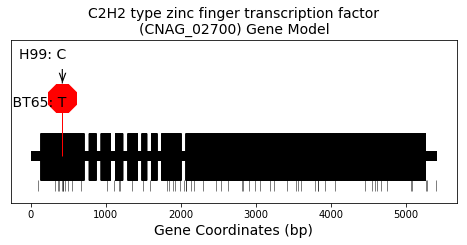

In [635]:
fig,ax = plt.subplots(1,1,figsize=(8,3))
plt.vlines(znf3.Posr.values,-1,1,linewidth=0.5);
plt.hlines(0,0,np.max(znf_start_stop) - np.min(znf_start_stop),linewidth=10);
plt.ylim(-2,5);
#plt.vlines(utr + basein ,
#           0,2,color='r',linewidth=1);
plt.vlines(znf3.Posr.values[-(basein+1)],
           0,2,color='r',linewidth=1);
plt.title('%s\n(CNAG_02700) Gene Model'%what_zft,fontsize=14)
#plt.vlines(znf3[(znf3.GV==1)].Posr.values,-1.5,-1,linewidth=0.5)
plt.vlines(all_zft_gv,-1.5,-1,linewidth=0.5)
plt.text(s='H99: C\n\n\n BT65: T',x=znf3.Posr.values[-(basein+1)]+60,
         y=2,ha='right',va='bottom',fontsize=14)
plt.text(s='<',rotation=90,x=znf3.Posr.values[-(basein+1)]+2,y=3.5,va='center',ha='center',fontsize=14)
plt.text(s='|',x=znf3.Posr.values[-(basein+1)],y=3.5,va='center',ha='center',fontsize=14)
plt.plot(znf3.Posr.values[-(basein+1)],2.5,'r8',markersize=30)
plt.yticks([])
plt.xlabel('Gene Coordinates (bp)',fontsize=14);
#plt.savefig('../FIGS/%s_gene_model.png'%'CNAG_02700',
            dpi=100,bbox_inches='tight');

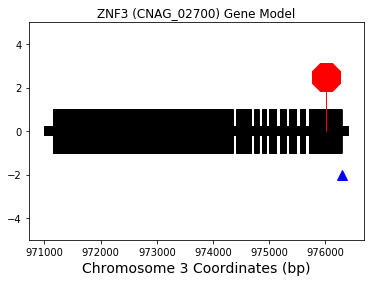

In [563]:
plt.vlines(znf3.Pos.values,-1,1,linewidth=0.5);
plt.hlines(0,np.min(znf_start_stop),np.max(znf_start_stop),linewidth=10);
plt.ylim(-5,5);
plt.vlines(znf3.Pos.values[-(basein+1)],
           0,2,color='r',linewidth=1);
plt.title('ZNF3 (CNAG_02700) Gene Model')

plt.plot(znf3.Pos.values[-(basein+1)],2.5,'r8',markersize=30)

start = [znf3.Pos.max() if znf3.Strand.unique() == '-' else znf3.Pos.min()]
plt.plot(start,-2,'b^',markersize=10)
plt.xlabel('Chromosome 3 Coordinates (bp)',fontsize=14);

In [95]:
qtl11df = []
for g in gene_11:
    if g in didnt_11:
        continue
    else:
        qtl11df.append(pd.read_csv('../FILES/GENES/%s.csv'%g,index_col=0))
qtl11df = pd.concat(qtl11df)

In [120]:
gene11_diffs = []
for g in qtl11df.Gene.unique():
    total_gv = gtd[(gtd.Chrom==qtl11df[(qtl11df.Gene==g)].Chrom.unique().max()) & 
    (gtd.Pos<= h99gff[(h99gff.Gene==g) & (h99gff.Type=='gene')].End.max()) & 
    (gtd.Pos>= h99gff[(h99gff.Gene==g) & (h99gff.Type=='gene')].Start.min())].shape[0]
    
    gv_in_cds = qtl11df[(qtl11df.Gene==g)].GV.sum()
    
    gene11_diffs.append((g,total_gv,gv_in_cds,nonsynonmous(qtl11df[(qtl11df.Gene==g)][['Ref','Alt','Strand']])))
gene11_diffsdf = pd.DataFrame(gene11_diffs)
gene11_diffsdf.columns = ['Gene','# of SNPs','SNPs in Exons','# Nsyn changes']
gene11_diffsdf['Stop-gain'] = 'no'
gene11_diffsdf['Stop-loss'] = 'no'
gene11_diffsdf.index = gene11_diffsdf.Gene

In [121]:
gene11_diffsdf[(gene11_diffsdf['# Nsyn changes']>0)].shape

(62, 6)

In [122]:
max11df = qtl11df.groupby('Gene').max()

In [123]:
max11df[(max11df['FASTA=REF']==0)]

,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
Gene,,,,,,,,,,,,,,,,,


In [124]:
max11df[(max11df['ALT=REF']==0)]

,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
Gene,,,,,,,,,,,,,,,,,
CNAG_01836,1044262,7.0,2.0,T,+,T,T,Chr_11,1,1,0,0,0,1,0,0,0
CNAG_07610,1119506,2.0,0.0,T,+,T,T,Chr_11,1,1,0,0,1,1,0,0,1
CNAG_07611,1170866,2.0,0.0,T,-,T,T,Chr_11,1,1,0,0,0,1,0,0,0


In [125]:
for gene,j in max11df[(max11df['FASTA=ALT']==0)].iterrows():
    
    if j['ALT>FASTA'] == 0:
        
        gene11_diffsdf.loc[gene,'Stop-gain'] = 'yes'
    else:
        assert j['ALT>FASTA'] == 1
        gene11_diffsdf.loc[gene,'Stop-loss'] = 'yes'

In [126]:
gene11_diffsdf[(gene11_diffsdf['Stop-gain'] == 'yes') | (gene11_diffsdf['Stop-loss']=='yes')]

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss
Gene,,,,,,
CNAG_07611,CNAG_07611,6,3,3,yes,no
CNAG_07610,CNAG_07610,8,3,2,no,yes
CNAG_01836,CNAG_01836,29,21,12,yes,no


In [127]:
gene3_diffsdf['Chromosome'] = 3 
gene11_diffsdf['Chromosome'] = 11

In [173]:
didnt_3_analysis = pd.DataFrame(index=didnt_3,columns=gene3_diffsdf.columns)
didnt_3_analysis['Gene'] = didnt_3
didnt_3_analysis['Chromosome'] = 3
didnt_3_analysis['Stop-gain'] = 'no'
didnt_3_analysis['Stop-loss'] = 'no'

for gene, j in didnt_3_analysis.iterrows():
    
    Start,End = h99gff[(h99gff.Type=='gene') & (h99gff.Gene==gene)][['Start','End']].values[0]
    didnt_3_analysis.loc[gene,'# of SNPs'] = gtd[(gtd.Chrom==3) & 
                                                 (gtd.Pos<= End) & (gtd.Pos>=Start)].shape[0]
didnt_3_analysis.fillna(0,inplace=True)
    
didnt_11_analysis = pd.DataFrame(index=didnt_11,columns=gene11_diffsdf.columns)
didnt_11_analysis['Gene'] = didnt_11
didnt_11_analysis['Chromosome'] = 11
didnt_11_analysis['Stop-gain'] = 'no'
didnt_11_analysis['Stop-loss'] = 'no'

for gene, j in didnt_11_analysis.iterrows():
    
    Start,End = h99gff[(h99gff.Type=='gene') & (h99gff.Gene==gene)][['Start','End']].values[0]
    didnt_11_analysis.loc[gene,'# of SNPs'] = gtd[(gtd.Chrom==11) & 
                                                  (gtd.Pos<= End) & (gtd.Pos>=Start)].shape[0]
    
didnt_11_analysis.fillna(0,inplace=True)

In [293]:
gene_analysis = pd.concat([gene3_diffsdf,gene11_diffsdf,
                           didnt_3_analysis,didnt_11_analysis],axis=0)

In [294]:
gene_analysis.tail()

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss,Chromosome
CNAG_13011,CNAG_13011,0,0,0,no,no,11
CNAG_13014,CNAG_13014,0,0,0,no,no,11
CNAG_13012,CNAG_13012,0,0,0,no,no,11
CNAG_13008,CNAG_13008,0,0,0,no,no,11
CNAG_13010,CNAG_13010,0,0,0,no,no,11


In [295]:
gene_analysis[(gene_analysis['# Nsyn changes']>0)].groupby('Chromosome').count()

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss
Chromosome,,,,,,
3,71,71,71,71,71,71
11,62,62,62,62,62,62


In [296]:
gene_analysis_gene_ix = gene_analysis.index.tolist()

In [297]:
analysis_gff = h99gff[(h99gff.Type=='gene') & (h99gff.Gene.isin(gene_analysis_gene_ix))].copy()

In [298]:
analysis_gff['Description'] = [' '.join(a.split(';description=')[-1].split('%2C')) for a in analysis_gff.ID.tolist()]

In [303]:
gene_analysis_new = gene_analysis.merge(analysis_gff[['Gene','Description']])

In [304]:
gene_analysis_new.head()

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss,Chromosome,Description
0,CNAG_02684,34,8,1,no,no,3,hypothetical protein
1,CNAG_02670,12,6,1,no,no,3,bud emergence protein 1
2,CNAG_02659,19,6,3,no,no,3,hypothetical protein hypothetical protein va...
3,CNAG_02689,13,4,3,no,no,3,hypothetical protein
4,CNAG_02711,0,0,0,no,no,3,hypothetical protein


In [305]:
gene_analysis_new.to_excel('../FIGS/paper/Supplementary_Tabel_S2.xlsx',index=False)

In [302]:
gene_analysis

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss,Chromosome
CNAG_02684,CNAG_02684,34,8,1,no,no,3
CNAG_02670,CNAG_02670,12,6,1,no,no,3
CNAG_02659,CNAG_02659,19,6,3,no,no,3
CNAG_02689,CNAG_02689,13,4,3,no,no,3
CNAG_02711,CNAG_02711,0,0,0,no,no,3
CNAG_02703,CNAG_02703,26,14,6,no,no,3
CNAG_02713,CNAG_02713,27,2,1,no,no,3
CNAG_02654,CNAG_02654,55,45,5,no,no,3
CNAG_02660,CNAG_02660,22,18,7,no,no,3
CNAG_02730,CNAG_02730,16,11,1,no,no,3


In [292]:
gene_analysis

,Gene,# of SNPs,SNPs in Exons,# Nsyn changes,Stop-gain,Stop-loss,Chromosome,Description


In [568]:
max11df[(max11df['FASTA=ALT']==0)]

,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
Gene,,,,,,,,,,,,,,,,,
CNAG_01836,1044262,7.0,2.0,T,+,T,T,Chr_11,1,1,0,0,0,1,0,0,0
CNAG_07610,1119506,2.0,0.0,T,+,T,T,Chr_11,1,1,0,0,1,1,0,0,1
CNAG_07611,1170866,2.0,0.0,T,-,T,T,Chr_11,1,1,0,0,0,1,0,0,0


In [78]:
unknown_07611 = pd.read_csv('../FILES/GENES/CNAG_07611.csv')

In [92]:
h99gff[(h99gff.Gene=='CNAG_07611') & (h99gff.Type=='CDS')][['Start','End']].diff(axis=1)['End'].sum()/3

67.33333333333333

In [94]:
unknown_07611_se = h99gff[(h99gff.Gene=='CNAG_07611')&(h99gff.Type=='gene')][['Start','End']]

In [98]:
unknown_07611['Posr'] = np.max(unknown_07611_se.values) - unknown_07611.Pos.values

In [101]:
np.max(unknown_07611_se)

Start    1170371
End      1170866
dtype: int64

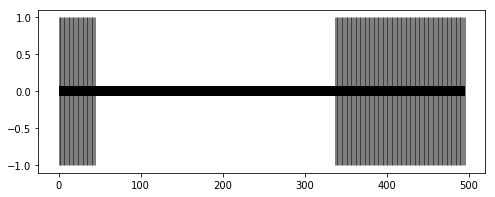

In [102]:
fig,ax = plt.subplots(1,1,figsize=(8,3))
plt.vlines(unknown_07611.Posr.values,-1,1,linewidth=0.5);
plt.hlines(0,0,np.max(unknown_07611_se.values) - np.min(unknown_07611_se.values),linewidth=10);



In [ ]:
plt.hlines(0,0,np.max(znf_start_stop) - np.min(znf_start_stop),linewidth=10);
plt.ylim(-2,5);
#plt.vlines(utr + basein ,
#           0,2,color='r',linewidth=1);
plt.vlines(znf3.Posr.values[-(basein+1)],
           0,2,color='r',linewidth=1);
plt.title('%s\n(CNAG_02700) Gene Model'%what_zft,fontsize=14)
#plt.vlines(znf3[(znf3.GV==1)].Posr.values,-1.5,-1,linewidth=0.5)
plt.vlines(all_zft_gv,-1.5,-1,linewidth=0.5)
plt.text(s='H99: C\n\n\n BT65: T',x=znf3.Posr.values[-(basein+1)]+60,
         y=2,ha='right',va='bottom',fontsize=14)
plt.text(s='<',rotation=90,x=znf3.Posr.values[-(basein+1)]+2,y=3.5,va='center',ha='center',fontsize=14)
plt.text(s='|',x=znf3.Posr.values[-(basein+1)],y=3.5,va='center',ha='center',fontsize=14)
plt.plot(znf3.Posr.values[-(basein+1)],2.5,'r8',markersize=30)
plt.yticks([])
plt.xlabel('Gene Coordinates (bp)',fontsize=14);

In [93]:
3*len(Seq(''.join(unknown_07611.Alt.tolist())).reverse_complement().translate(to_stop=True))

120

In [81]:
len(Seq(''.join(unknown_07611.Ref.tolist())).reverse_complement().translate(to_stop=True))

67

In [79]:
unknown_07611.head()

,Pos,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
0,1170371,1170371,2.0,0.0,T,-,T,T,CNAG_07611,Chr_11,1,0,0,0,0,1,0,0,0
1,1170372,1170372,2.0,0.0,C,-,C,C,CNAG_07611,Chr_11,1,0,0,0,0,1,0,0,0
2,1170373,1170373,2.0,0.0,A,-,A,A,CNAG_07611,Chr_11,1,0,0,0,0,1,0,0,0
3,1170374,1170374,2.0,0.0,C,-,C,C,CNAG_07611,Chr_11,1,0,0,0,0,1,0,0,0
4,1170375,1170375,2.0,0.0,C,-,C,C,CNAG_07611,Chr_11,1,0,0,0,0,1,0,0,0


In [569]:
h99gff[(h99gff.Type=='gene') & (h99gff.Gene.isin(max11df[(max11df['ALT=REF']==0)].index))]

,Chrom,Source,Type,Start,End,Skip,Strand,Phase,ID,Gene
12726,CP003830.1,EuPathDB,gene,1170371,1170866,.,-,.,ID=CNAG_07611;description=hypothetical protein,CNAG_07611
91300,CP003830.1,EuPathDB,gene,1119077,1119717,.,+,.,ID=CNAG_07610;description=hypothetical protein,CNAG_07610
113956,CP003830.1,EuPathDB,gene,1042367,1044262,.,+,.,ID=CNAG_01836;description=long-chain acyl-CoA ...,CNAG_01836


In [574]:
what_coa = 'long-chain acyl-CoA synthetase'

In [584]:
coa  = pd.read_csv('../FILES/GENES/CNAG_01836.csv')

In [612]:
coa.tail()

,Pos,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
1561,1044258,1044258,7.0,0.0,A,+,A,A,CNAG_01836,Chr_11,1,0,0,0,0,1,0,0,0
1562,1044259,1044259,7.0,0.0,T,+,T,T,CNAG_01836,Chr_11,1,0,0,0,0,1,0,0,0
1563,1044260,1044260,7.0,0.0,T,+,T,T,CNAG_01836,Chr_11,1,0,0,0,0,1,0,0,0
1564,1044261,1044261,7.0,0.0,A,+,A,A,CNAG_01836,Chr_11,1,0,0,0,0,1,0,0,0
1565,1044262,1044262,7.0,0.0,A,+,A,A,CNAG_01836,Chr_11,1,0,0,0,0,1,0,0,0


In [573]:
len(Seq(''.join(coa.Ref.tolist())).translate(to_stop=True))

521

In [581]:
coagff= h99gff[(h99gff.Gene=='CNAG_01836') & (h99gff.Type=='gene')]
coa_start_stop = coagff[['Start','End']].values[0]
coa_start_stop

array([1042367, 1044262])

In [575]:
coa_alt_len = len(Seq(''.join(coa.Alt.tolist())).translate(to_stop=True))

In [602]:
coa_basein = 3*coa_alt_len

In [610]:
Seq(''.join(coa.Ref.tolist()))[:coa_basein+3]

Seq('ATGACTTCTCTCAACTCCTTTCCTCTATTCGAGCGCATAATTACCCACGCTCAG...TGG')

In [611]:
Seq(''.join(coa.Alt.tolist()))[:coa_basein+3]

Seq('ATGACTTCTCTCAACTCCTTTCCTCTATTCGAGCGCATAATTACCCACGCTCAG...TGA')

In [613]:
coa[(coa.GV==1)].tail()

,Pos,Pos.1,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,Parent,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
1169,1043712,1043712,4.0,0.0,C,+,C,A,CNAG_01836,Chr_11,1,1,0,0,0,1,0,0,0
1293,1043877,1043877,5.0,0.0,G,+,G,A,CNAG_01836,Chr_11,1,1,0,0,0,1,0,0,0
1310,1043894,1043894,5.0,0.0,A,+,A,G,CNAG_01836,Chr_11,1,1,0,0,0,1,0,0,0
1511,1044208,1044208,7.0,0.0,G,+,G,A,CNAG_01836,Chr_11,1,1,0,0,0,1,0,0,0
1533,1044230,1044230,7.0,0.0,C,+,C,A,CNAG_01836,Chr_11,1,1,0,0,0,1,0,0,0


In [640]:
all_coa_gv = gtd[(gtd.Chrom=='Chr_11') & 
            (gtd.Pos.isin(np.arange(coa_start_stop[0],coa_start_stop[1]+1)))].Pos.values -np.min(coa_start_stop)

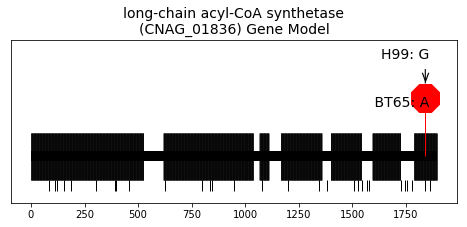

In [643]:
fig,ax = plt.subplots(1,1,figsize=(8,3))
plt.vlines(coa.Pos.values-coa.Pos.min(),-1,1,linewidth=0.5);
plt.hlines(0,0,np.max(coa_start_stop)-np.min(coa_start_stop),linewidth=10);
plt.vlines(coa.Pos.values[coa_basein]-coa.Pos.min(),
           0,2,color='r',linewidth=1);
plt.vlines(all_coa_gv,-1.5,-1,linewidth=1)

plt.plot(coa.Pos.values[coa_basein]-coa.Pos.min(),2.5,'r8',markersize=30)

plt.text(s='<',rotation=90,x=coa.Pos.values[coa_basein]-coa.Pos.min(),
         y=3.5,va='center',ha='center',fontsize=14)
plt.text(s='|',x=coa.Pos.values[coa_basein]-coa.Pos.min(),
         y=3.5,va='center',ha='center',fontsize=14)

plt.text(s='H99: G\n\n\n BT65: A',x=coa.Pos.values[coa_basein]-coa.Pos.min()+20,
         y=2,ha='right',va='bottom',fontsize=14)

plt.title('%s\n(CNAG_01836) Gene Model'%what_coa,fontsize=14)

plt.yticks([])
plt.ylim(-2,5);
#plt.savefig('../FIGS/%s_gene_model.png'%'CNAG_01836',
            dpi=100,bbox_inches='tight');

In [268]:

#plt.vlines(utr + basein ,
#           0,2,color='r',linewidth=1);
plt.vlines(coa.Posr.values[-(basein+1)],
           0,2,color='r',linewidth=1);
plt.title('%s () Gene Model'%what_coa)
plt.text(s='H99: C\n\n\n BT65: T',x=coa.Posr.values[-(basein+1)]+60,
         y=2,ha='right',va='bottom',fontsize=14)
plt.text(s='<',rotation=90,x=coa.Posr.values[-(basein+1)]+2,y=3.5,va='center',ha='center',fontsize=14)
plt.text(s='|',x=coa.Posr.values[-(basein+1)],y=3.5,va='center',ha='center',fontsize=14)
plt.plot(coa.Posr.values[-(basein+1)],2.5,'r8',markersize=30)
plt.yticks([])
plt.xlabel('Gene Coordinates (bp)',fontsize=14);
#plt.savefig('../FIGS/COA_gene_model.png',dpi=100,bbox_inches='tight');

8

In [251]:
cdsdf.head()

,Pos,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,GV,Refflag,ALT=REF,ATL>REF,FASTA=REF,FASTA=ALT,REF>FASTA,ALT>FASTA
Pos,,,,,,,,,,,,,,,,,
971147,971147,9,0,T,-,T,T,CNAG_02700,Chr_3,0,0,0,0,1,0,0,0
971148,971148,9,0,C,-,C,C,CNAG_02700,Chr_3,0,0,0,0,1,0,0,0
971149,971149,9,0,A,-,A,A,CNAG_02700,Chr_3,0,0,0,0,1,0,0,0
971150,971150,9,0,C,-,C,C,CNAG_02700,Chr_3,0,0,0,0,1,0,0,0
971151,971151,9,0,C,-,C,C,CNAG_02700,Chr_3,0,0,0,0,1,0,0,0


95

In [247]:
len(refseq.translate(to_stop=True))

1561

In [249]:
len(fastaseq.translate(to_stop=True))

1561

In [243]:
altseq = Seq(''.join(cdsdf.Alt.tolist())).reverse_complement()
refseq = Seq(''.join(cdsdf.Ref.tolist())).reverse_complement()
fastaseq = Seq(''.join(cdsdf.Fasta.tolist())).reverse_complement()

In [233]:
transeq = []
for v,a in cdsdf.groupby('CDS'):
    if a.Strand.min() == '-':
        transeq.append(Seq(''.join(a.Ref.tolist())).reverse_complement)

In [234]:
transeq

[Seq('ACCGTCGTAGTTATTCTCAACAGTCTTCTCATTGACCTCCCCCTCAGCTTCCCA...CAT'),
 Seq('CCCATCCTGGCTATCCTCTACAGCCCTGTAGCTTGAAGTGGAATCATCCAAAGA...CCG'),
 Seq('GTCATAACCATGGTCGAAAGTATCGGTTGAGCGGACTTGGTGAGGGGGAAGGGG...CTC'),
 Seq('CTGTTGAAGAGCAGCTGCCGACTTGAATTGCTTATTGCAAGGCTTGCAGACAGG...GTA'),
 Seq('ATCGAATGAAGACTTGGGACGTCCTGCAGATGATGTCACAGATCCTGGAGCGGG...ATG'),
 Seq('CTGTCGCAGATCATATGCGCTGTGGTAGTCTTCATTGCAGATCTCACACATGTA...ATC'),
 Seq('GTCGCGCGCCTCATGTGCATGAGCGAAGGTGACGAGACATTCAGGACAGAGCAT...ATG'),
 Seq('AGCTCTGAGGTCCATGGCGTTCGGGAATACCATATCACACTGCTGACAGCGATG...GTG'),
 Seq('TCACCAGCCACCAGTGTCTCCATCGGCCACGCCTGGAAGTGAACCCCAGTTATT...GTG')]

In [215]:
cdsdf.tail()

,Pos,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,GV,Refflag
Pos,,,,,,,,,,,
976285,976285,1,0,A,-,A,A,CNAG_02700,Chr_3,0,0
976286,976286,1,0,G,-,G,G,CNAG_02700,Chr_3,0,0
976287,976287,1,0,C,-,C,C,CNAG_02700,Chr_3,0,0
976288,976288,1,0,A,-,A,A,CNAG_02700,Chr_3,0,0
976289,976289,1,0,T,-,T,T,CNAG_02700,Chr_3,0,0


In [212]:
cdsdf[(cdsdf.Refflag==1)]

,Pos,CDS,Phase,Fasta,Strand,Ref,Alt,Gene,Chrom,GV,Refflag
Pos,,,,,,,,,,,


In [189]:
gene_gv.Pos

,Chrom,Pos,DP,QUAL,maf,VType,Lalt,nottel,notcen,41,...,8,22,3,2,Ref,Alt,Bt65,crg1,Pval,ANN
Pos,,,,,,,,,,,,,,,,,,,,,
971321,Chr_3,971321,5694,86428.7,0.500000,snp,1,1.0,1.0,1,...,1,0,1,1,C,T,1.0,0.0,1.422483,['T|synonymous_variant|LOW|CNAG_02700|CNAG_027...
971334,Chr_3,971334,5694,85138.3,0.500000,snp,1,1.0,1.0,1,...,1,0,1,1,C,T,1.0,0.0,1.422483,['T|missense_variant|MODERATE|CNAG_02700|CNAG_...
971666,Chr_3,971666,5320,80409.5,0.535714,snp,1,1.0,1.0,1,...,1,0,1,1,C,T,1.0,0.0,1.422483,['T|synonymous_variant|LOW|CNAG_02700|CNAG_027...
971744,Chr_3,971744,5437,82257.8,0.500000,snp,1,1.0,1.0,1,...,1,0,1,1,G,A,1.0,0.0,1.422483,['A|synonymous_variant|LOW|CNAG_02700|CNAG_027...
971792,Chr_3,971792,5352,81931.7,0.464286,snp,1,1.0,1.0,1,...,1,0,1,1,G,A,1.0,0.0,1.422483,['A|synonymous_variant|LOW|CNAG_02700|CNAG_027...
971817,Chr_3,971817,5300,83310.1,0.500000,snp,1,1.0,1.0,1,...,1,0,1,1,T,C,1.0,0.0,1.422483,['C|missense_variant|MODERATE|CNAG_02700|CNAG_...
971862,Chr_3,971862,5132,78853.0,0.500000,snp,1,1.0,1.0,1,...,1,0,1,1,G,C,1.0,0.0,1.422483,['C|missense_variant|MODERATE|CNAG_02700|CNAG_...
971960,Chr_3,971960,5411,82813.2,0.464286,snp,1,1.0,1.0,1,...,1,0,1,1,G,A,1.0,0.0,1.422483,['A|synonymous_variant|LOW|CNAG_02700|CNAG_027...
972361,Chr_3,972361,3140,2658.1,0.464286,snp,1,1.0,1.0,1,...,1,0,1,1,C,T,1.0,0.0,1.422483,['T|missense_variant|MODERATE|CNAG_02700|CNAG_...


In [128]:
cdsgff

,Chrom,Source,Type,Start,End,Skip,Strand,Phase,ID,Gene,CDS
0,CP003822.1,EuPathDB,CDS,971147,974353,.,-,0,ID=CNAG_02700-t26_1-p1-CDS9;Parent=CNAG_02700-...,CNAG_02700,9
1,CP003822.1,EuPathDB,CDS,974412,974678,.,-,0,ID=CNAG_02700-t26_1-p1-CDS8;Parent=CNAG_02700-...,CNAG_02700,8
2,CP003822.1,EuPathDB,CDS,974733,974813,.,-,0,ID=CNAG_02700-t26_1-p1-CDS7;Parent=CNAG_02700-...,CNAG_02700,7
3,CP003822.1,EuPathDB,CDS,974870,974941,.,-,0,ID=CNAG_02700-t26_1-p1-CDS6;Parent=CNAG_02700-...,CNAG_02700,6
4,CP003822.1,EuPathDB,CDS,974991,975128,.,-,0,ID=CNAG_02700-t26_1-p1-CDS5;Parent=CNAG_02700-...,CNAG_02700,5
5,CP003822.1,EuPathDB,CDS,975190,975297,.,-,0,ID=CNAG_02700-t26_1-p1-CDS4;Parent=CNAG_02700-...,CNAG_02700,4
6,CP003822.1,EuPathDB,CDS,975355,975486,.,-,0,ID=CNAG_02700-t26_1-p1-CDS3;Parent=CNAG_02700-...,CNAG_02700,3
7,CP003822.1,EuPathDB,CDS,975547,975645,.,-,0,ID=CNAG_02700-t26_1-p1-CDS2;Parent=CNAG_02700-...,CNAG_02700,2
8,CP003822.1,EuPathDB,CDS,975547,975648,.,-,0,ID=CNAG_02700-t26_2-p1-CDS2;Parent=CNAG_02700-...,CNAG_02700,2
9,CP003822.1,EuPathDB,CDS,975708,976289,.,-,0,ID=CNAG_02700-t26_1-p1-CDS1;Parent=CNAG_02700-...,CNAG_02700,1


In [119]:
cdscds

[array([104177., 104177., 104177., ..., 104177., 104177., 104177.]),
 array([104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        104179., 104179., 104179., 104179., 104179., 104179., 104179.,
        

In [ ]:
cdsdf = pd.DataFrame(  )

In [116]:
''.join([str(a) for a in cdsseq])

'TCACCAGCCACCAGTGTCTCCATCGGCCACGCCTGGAAGTGAACCCCAGTTATTGTTCTGTGGCGGGGACACGGTTGTTGAATTGGAAAATGATGCCCTTCTATTGTCATCCCATCCCTGTCTCGAACCCTGCCTATCGTTCGGGCTCCATCCGCTATCACCATCATCTCCATACCTACCCGCACTACCTCCATAACGATCATTATGGTACGACTTTGGATCCATCGAGATCCAACCGGACTCGTCTACACCATTGAAGCTTGAACTTCTAACCGACGTGGTCCCTTTCCTCCTCTCGCGGTCCTTTGCTCTCTCGTCCTCAACCTCAGCCCTAGCAGAACGCATCTTCTCCAGAGCGTTTGTCGAATTCTTGAACGGCCTCGGGATGGGTTTGGGACCCCAGCCGTTAGACCCTGTAGAGTTGCGCTTCCTAATGGGACCGTGGTTGTTTATTCTCCTGTTGGGAGGGAATCTGAACGAACGAGAGTCGTCTTCGTAACTGTCTCTATCCCTTATGGGCGCAAGGTTGAGAGGAGGACGGGCACGGTTGGCAATGGCGATGCGATACACCTCTTCGGACTCCGCCCAATGATCATCGTCGGCAGGCGCGATGGAAGGAATGAGTTGCTCAGACTCGGCCGTGCGGGCTTCGACTGTTCCTTCTTCATGCTCTTCACTGGTAGAAAGTGAGAGAGGAGCGCTGGTGATGGTGGCAGTGTTCGATTCGGAGAAGGTGAATGAAGGAACGGAAAACTCAATGTTACCGATCATGGACGGTTCATCTTCTGTGATAGCAGGGGCGACGGCAGCAGCGGCAGCAAACTCCGCTTCAGCTTCAGCCAGAGCCTGAGCAGCACGAGCAGCCTCCTCCGCTTCAATCGCCGCCAGCTCCTCCTCGCGTGCAACTCCGGCGCCAGCACCTTCCATCACTGGTGACGCAGAAGAAGCTATTTGCATAGATTCAGCCGGTTGTTCTGGGCTGTGGGTGACAGCGCTGCG

In [ ]:
ch3_h99 = sorted(h99gff.Chrom.unique())[2]
ch11_h99 = sorted(h99gff.Chrom.unique())[10]

In [ ]:
gene_locs = h99gff[(h99gff.Type=='gene') & (h99gff.Chrom.isin([ch3_h99,ch11_h99]))].copy().reset_index(drop=True)

In [ ]:
gene_locs.shape

In [ ]:
fundb_h99 = [s for s in SeqIO.parse(Fungidb_fasta_path,format='fasta') if s.id in [ch3_h99,ch11_h99]]
assert len(fundb_h99) == 2

In [ ]:
gene_locs['Name'] = [a.split(';')[0].split('D=')[1] for a in gene_locs.ID.tolist()]

In [ ]:
gene_locs.sort_values(['Chrom','Start'],inplace=True)

In [ ]:
gene_locs.head()

In [ ]:
gene_seq = []

for i,j in gene_locs.iterrows():
    
    if j.Chrom == ch3_h99:
        k = 0
    else:
        k = 1
        
    fasta = fundb_h99[k].seq
    
    name = j.Name
    strand = j.Strand
    
    if strand == '-':
        gs = fasta[j.Start-1:j.End].reverse_complement()
    else:
        gs = fasta[j.Start-1:j.End]
    
    seqrec = SeqRecord(seq=gs,id='%s_%s_%s_%s'%(j.Chrom,j.Start,j.End,name),name=str(i)) 
    gene_seq.append(seqrec)

In [ ]:
assert len(gene_seq) == gene_locs.shape[0]

In [ ]:
reads_path = '../FILES/H99_%s_%s_genes.fasta'%(ch3_h99,ch11_h99)
genefile = open(reads_path,'w')
[SeqIO.write(s,handle=genefile,format='fasta') for s in gene_seq]
genefile.close()

In [ ]:
%%bash
/Users/croth/Desktop/CRYPTO_QTL/SCRIPTS/./blat /Users/croth/Desktop/Hypermutator/DATA/H99_latest_Vikas_assembly.fasta /Users/croth/Desktop/Hypermutator/FILES/H99_CP003822.1_CP003830.1_genes.fasta /Users/croth/Desktop/Hypermutator/FILES/H99_fundb_to_vikas.psl

In [ ]:
psl = parse_psl('/Users/croth/Desktop/Hypermutator/FILES/H99_fundb_to_vikas.psl') 

In [ ]:
psl['Gene'] = ['CNA'+a.split('_CNA')[-1] for a in psl.Q_name]

In [ ]:
gene_locs.shape

In [ ]:
genes = gene_locs.Name.unique()

In [ ]:
len(genes)

In [ ]:
likely_locs = psl[(psl.T_name.isin(['Chr_3','Chr_11'])) & (psl.Q_frac == 1)].copy()

In [ ]:
likely_locs.Gene.unique().shape

In [ ]:
missing = [g for g in genes if g not in likely_locs.Gene.unique()]
missing

In [ ]:
dupplicated = [g for g in  genes if likely_locs[(likely_locs.Gene==g)].shape[0]>1]
dupplicated

In [ ]:
likely_locs['Old_start'] = [int(a.split('_')[1]) for a in likely_locs.Q_name.tolist()]
likely_locs['Old_end'] = [int(a.split('_')[2]) for a in likely_locs.Q_name.tolist()]

In [ ]:
likely_locs['Diff_start'] = likely_locs.Old_start - likely_locs.T_start
likely_locs['Diff_end'] = likely_locs.Old_end - likely_locs.T_end

In [ ]:
likely_locs.Diff_start.tolist().count(1)

In [ ]:
likely_locs[(likely_locs.Diff_start!=1)].shape

In [ ]:
werido = likely_locs[(likely_locs.Diff_start!=1)].Gene.tolist()[0]

In [ ]:
likely_locs.head()

In [ ]:
gene_locs[(gene_locs.Name==ZNF3)]

In [ ]:
chr3_bounds*1000

In [ ]:
chr11_bounds*1000

In [ ]:
chr3_genes = gene_locs[(gene_locs.End>=chr3_bounds[0]*1000) & 
          (gene_locs.Start<=chr3_bounds[1]*1000) &
          (gene_locs.Chrom==ch3_h99)]

chr11_genes = gene_locs[(gene_locs.End>=chr11_bounds[0]*1000) & 
          (gene_locs.Start<=chr11_bounds[1]*1000) &
          (gene_locs.Chrom==ch11_h99)]

In [ ]:
chr3_genes.shape

In [ ]:
chr11_genes.shape

In [ ]:
if len([a for a in missing if a in chr3_genes.Name.tolist()]) > 0:
    print('Error')

In [ ]:
if len([a for a in missing if a in chr11_genes.Name.tolist()]) >0:
    print('Error')

In [ ]:
if len([a for a in dupplicated if a in chr3_genes.Name.tolist()]) >0:
    print('Error')

In [ ]:
if len([a for a in dupplicated if a in chr11_genes.Name.tolist()]) >0:
    print('Error')

In [ ]:
assert werido not in chr3_genes.Name.tolist() and werido not in chr11_genes.Name.tolist()

In [ ]:
chr3_pos = np.arange(1000*chr3_bounds[0]-1,1000*chr3_bounds[1]+1)
chr11_pos = np.arange(1000*chr11_bounds[0]-1,1000*chr11_bounds[1]+1)

In [ ]:
chr3_pos[:5]

In [ ]:
chr11_gv = gtd[(gtd.Chrom=='Chr_11') & (gtd.Pos.isin(chr11_pos))]

In [ ]:
chr3_genes_ws = []
for i,j in chr3_genes.iterrows():
    
    gstart = j.Start
    gend = j.End
    
    gene_vars = chr3_gv[(chr3_gv.Pos.isin(np.arange(gstart-1,gend+1)))]
    
    if gene_vars.shape[0] > 0:
        chr3_genes_ws.append(i)

In [ ]:
chr3_pos = np.arange(1000*chr3_bounds[0]-1,1000*chr3_bounds[1]+1)

chr3_gv = gtd[(gtd.Chrom=='Chr_3') & (gtd.Pos.isin(chr3_pos))]

chr3_genes = gene_locs[(gene_locs.End>=chr3_bounds[0]*1000) & 
          (gene_locs.Start<=chr3_bounds[1]*1000) &
          (gene_locs.Chrom==ch3_h99)]


testgenes = [ZNF3]
for gname in testgenes:
    
    
    
    znf3gene = chr3_genes[(chr3_genes.Name==gname)]
    
    znf_gv = chr3_gv[(chr3_gv.Pos.isin(np.arange(znf3gene.Start.max(),znf3gene.End.max()+1)))].copy()
    znf_gv['CDS'] = -1
    znf_gv.index = znf_gv.Pos
    
    znf_gff = h99gff[(h99gff.Chrom==znf3gene.Chrom.max()) & 
                     (h99gff.End>=znf3gene.Start.max()) &
                     (h99gff.Start<=znf3gene.End.max())]
    
    
    znf_strand = znf_gff.Strand.unique()
    
    znf_cds = znf_gff[(znf_gff.Type=='CDS')]
    for i in znf_cds.Start.values:
        cdsseq =  fundb_h99[0].seq[znf_cds.Start.values[-1]-1:znf_cds.End.values[-1]]
        cdstest = pd.DataFrame([s for s in cdsseq])
        cdstest.columns = ['Ref'] 
        cdstest['Alt'] = cdstest['Ref']
        cdstest.index = np.arange(znf_cds.Start.values[-1],znf_cds.End.values[-1]+1)

In [ ]:
h99gff.T[[104171,104172]]

In [ ]:
znf_gff

In [ ]:
znf_cds.drop_duplicates()

In [ ]:
znf_cds

In [ ]:
znf_cds[['Start','End']].values

In [ ]:
znf3gene

In [ ]:
znf3gene.Start.max()

In [ ]:
znf_gff = h99gff[(h99gff.Chrom==znf3gene.Chrom.max()) & 
       (h99gff.Start>=znf3gene.Start.max()) &
       (h99gff.End<=znf3gene.End.max())]

In [ ]:
znf_gff.tail()

In [ ]:
znf_cds = znf_gff[(znf_gff.Type=='CDS')]
znf_cds.tail()

In [ ]:
for i,j in znf_gff[(znf_gff.Type=='CDS')].iterrows():
    
    cdstart = j.Start
    cdend = j.End
    
    znf_gv.loc[znf_gv.Pos.isin(np.arange(cdstart,cdend+1)),'CDS'] = 1

In [ ]:
cdsseq =  fundb_h99[0].seq[znf_cds.Start.values[-1]-1:znf_cds.End.values[-1]]
cdstest = pd.DataFrame([s for s in cdsseq])
cdstest.columns = ['Ref'] 
cdstest['Alt'] = cdstest['Ref']
cdstest.index = np.arange(znf_cds.Start.values[-1],znf_cds.End.values[-1]+1)

In [ ]:
cdsseq[-5:]

In [ ]:
cdstest.tail()

In [ ]:
incds = [p for p in znf_gv.Pos.tolist() if p in cdstest.index]

In [ ]:
cdstest.loc[incds,'Alt'] = znf_gv.loc[incds,'Alt']

In [ ]:
cdstest[(cdstest.Ref!=cdstest.Alt)].shape[0] == len(incds)

In [ ]:
ref = Seq(''.join(cdstest.Ref.tolist())).reverse_complement()
alt = Seq(''.join(cdstest.Alt.tolist())).reverse_complement()

In [ ]:
len(ref)

In [ ]:
len(alt)

In [ ]:
len(ref.translate(to_stop=True))

In [ ]:
len(alt.translate(to_stop=True))

In [ ]:
(194*3)

In [ ]:
95*3

In [ ]:
znf_cds.End.max() - 285

In [ ]:
znf_gv.loc[incds]

In [ ]:
np.sum([a.split('|')[1] == 'stop_gained' for a in chr3_gv.ANN])

In [ ]:
chr11_gv[([a.split('|')[1] == 'stop_gained' for a in chr11_gv.ANN])]

In [ ]:
np.sum([a.split('|')[1] == 'stop_gained' for a in gtd.ANN])

In [ ]:
gstart

In [ ]:
gend

In [ ]:
ch

In [ ]:
chr11_genes_ws = []
for i,j in chr11_genes.iterrows():
    
    gstart = j.Start
    gend = j.End
    
    gene_vars = chr11_gv[(chr11_gv.Pos.isin(np.arange(gstart-1,gend+1)))]
    
    if gene_vars.shape[0] > 0:
        chr11_genes_ws.append(i)

In [ ]:
len(chr11_genes_ws)

In [ ]:
chr11_genes.shape

In [ ]:
chr3_genes.shape

In [ ]:
len(chr3_genes_ws)

In [ ]:
chr3_gv.shape

In [ ]:
chr11_gv.shape

In [ ]:
gene_locs.shape

In [ ]:
gene_locs[(gene_locs)]

In [ ]:
likely_locs[(likely_locs.T_name=='Chr_11') & (likely_locs.Old_start)]

In [ ]:
likely_locs[(likely_locs.Gene==genes[0])]

In [ ]:
chrlist = gtd.Chrom.unique()

In [ ]:
samples = sorted_prog
## List samples we know to have aneuploidy
baddies = [['25'],['25'],['14','25'],['25','34'],
           ['25'],['25'],['25'],['25'],['25'],['25'],['13','14','25'],
           ['25'],['20','25','29'],['25']]
tobcols = other#[a for a in gtd.columns.tolist() if a not in samples]

In [ ]:
brix_v = []
brix_w = []
for chrom in chrlist:
    temp = gtd[(gtd.Chrom==chrom)].reset_index()
    cn = int(chrom.split('_')[-1])-1
    chrsamp = [s for s in samples if s not in baddies[cn]]
    brix = temp.loc[temp[chrsamp].diff().abs().sum(axis=1) > 0.0].index.tolist()
    brix_e = [temp.index.tolist()[0]] + list(brix) + [temp.index.tolist()[-1]]
    brix_v.append(np.array(brix_e[:-1]))
    brix_w.append(np.array(brix_e[1:])- 1)

In [ ]:
other

In [ ]:
len(samples) + len(other)

In [ ]:
bgeno.head()

In [ ]:
bchroms = []
for c,chrom in enumerate(chrlist):
    
    temp = gtd[(gtd.Chrom==chrom)].reset_index()
    bchroms.append(pd.concat([temp.loc[brix_v[c]][tobcols].reset_index(drop=True),
            temp.loc[brix_w[c]][['Pos']].reset_index(drop=True),
           temp.loc[brix_w[c]][samples].reset_index(drop=True)],axis=1))
    
bgeno = pd.concat(bchroms)
bgeno.drop(['VType','DP','Lalt','nottel','notcen','Ref','Alt','QUAL','ANN'],
           axis=1,inplace=True)
bgeno.columns = ['Chrom','Pos_v','maf','Bt65','crg1','Pval','Pos_w']+samples
bgeno['Pos_m'] = bgeno[['Pos_v','Pos_w']].mean(axis=1)

In [ ]:
bgeno.shape

In [ ]:
chr3b = bgeno[(bgeno.Chrom=='Chr_3')]
chr11b = bgeno[(bgeno.Chrom=='Chr_11')]

In [ ]:
chr3b.shape

In [ ]:
chr11b.shape

In [ ]:
chrom_corrs = []
done = []
for i,z in chr3b.iterrows():
    zs = np.array(z[samples],dtype=int)
    cc = []
    for j,k in chr11b.iterrows():
        ks = np.array(k[samples],dtype=int)
        corcoef = np.corrcoef(ks,zs)[0][1]
        cc.append(corcoef)
    chrom_corrs.append(cc)

In [ ]:
chr_3x11 = pd.DataFrame(chrom_corrs)

In [ ]:
chr_3x11.shape

In [ ]:
chr_3x11.columns = chr11b.Pos_m
chr_3x11.index = chr3b.Pos_m

In [ ]:
import seaborn as sns

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.heatmap(chr_3x11,cmap = 'cividis', 
            xticklabels=5,yticklabels=5);
plt.xlabel('Chromosome 11\nGenetic Variant Coordiantes',fontsize=14)
plt.ylabel('Chromosome 3\nGenetic Variant Coordinates',fontsize=14);